# Multi-Model Classification - Adult Census Income Dataset

Binary classification to predict whether annual income exceeds $50K based on census data.

## 1. Import Libraries

In [ ]:
import sys
!{sys.executable} -m pip install xgboost --user
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import os
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    confusion_matrix,
    classification_report
)

print("Libraries imported successfully")

Libraries imported successfully


## 2. Load Adult Census Income Dataset

**Note:** If UCI package doesn't work, uncomment the direct URL download method below.

In [ ]:
#Method 1
try:
    from ucimlrepo import fetch_ucirepo

    print("Downloading Adult Census Income dataset using UCI package...")
    adult = fetch_ucirepo(id=2)

    X = adult.data.features
    y = adult.data.targets

    df = pd.concat([X, y], axis=1)
    df = df.rename(columns={'income': 'target'})

    print("UCI package method successful")

except Exception as e:
    print(f"UCI package failed: {e}")
    print("Trying direct URL download...")

    # METHOD 2
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

    column_names = [
        'age', 'workclass', 'fnlwgt', 'education', 'education-num',
        'marital-status', 'occupation', 'relationship', 'race', 'sex',
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'target'
    ]

    df = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)
    print("Direct URL download successful")

# Convert target to binary (0: <=50K, 1: >50K)
df['target'] = df['target'].apply(lambda x: 1 if '>50K' in str(x) else 0)

# Handle missing values
df = df.replace('?', np.nan)
df = df.dropna()

# Encode categorical features
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'target' in categorical_cols:
    categorical_cols.remove('target')

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

df['target'] = df['target'].astype(int)

print(f"\nDataset shape: {df.shape}")
print(f"Features: {len(df.columns) - 1}")
print(f"Instances: {len(df)}")
print(f"\nTarget distribution:\n{df['target'].value_counts()}")
df.head()

UCI package failed: No module named 'ucimlrepo'
Trying direct URL download...
Direct URL download successful

Dataset shape: (30162, 15)
Features: 14
Instances: 30162

Target distribution:
target
0    22654
1     7508
Name: count, dtype: int64


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,4,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,2,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,2,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,2,338409,9,13,2,9,5,2,0,0,0,40,4,0


## 3. Data Exploration

In [ ]:
print("Dataset Information:")
print(df.info())
print("\nDataset Statistics:")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())
print("\nTarget distribution:")
print(df['target'].value_counts())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             30162 non-null  int64
 1   workclass       30162 non-null  int64
 2   fnlwgt          30162 non-null  int64
 3   education       30162 non-null  int64
 4   education-num   30162 non-null  int64
 5   marital-status  30162 non-null  int64
 6   occupation      30162 non-null  int64
 7   relationship    30162 non-null  int64
 8   race            30162 non-null  int64
 9   sex             30162 non-null  int64
 10  capital-gain    30162 non-null  int64
 11  capital-loss    30162 non-null  int64
 12  hours-per-week  30162 non-null  int64
 13  native-country  30162 non-null  int64
 14  target          30162 non-null  int64
dtypes: int64(15)
memory usage: 3.7 MB
None

Dataset Statistics:
                age     workclass        fnlwgt     education  education-num  \

## 4. Preprocessing and Train-Test Split

In [ ]:
# Create model directory
os.makedirs('model', exist_ok=True)

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save artifacts for deployment
joblib.dump(scaler, 'model/preprocessing_pipeline.pkl')
X_test.to_csv('model/test_data.csv', index=False)
y_test.to_csv('model/test_labels.csv', index=False)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (24129, 14)
Test set: (6033, 14)


## 5. Model Evaluation Function

In [ ]:
def evaluate_model(model, X_test, y_test, y_pred, y_pred_proba=None):
    """
    Calculate all required metrics for model evaluation
    """
    metrics = {}

    metrics['Accuracy'] = accuracy_score(y_test, y_pred)

    # AUC calculation
    if y_pred_proba is not None:
        if len(np.unique(y_test)) == 2:
            metrics['AUC'] = roc_auc_score(y_test, y_pred_proba[:, 1])
        else:
            metrics['AUC'] = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    else:
        metrics['AUC'] = 'N/A'

    # Precision, Recall, F1
    avg_method = 'binary' if len(np.unique(y_test)) == 2 else 'weighted'
    metrics['Precision'] = precision_score(y_test, y_pred, average=avg_method, zero_division=0)
    metrics['Recall'] = recall_score(y_test, y_pred, average=avg_method, zero_division=0)
    metrics['F1'] = f1_score(y_test, y_pred, average=avg_method, zero_division=0)

    # Matthews Correlation Coefficient
    metrics['MCC'] = matthews_corrcoef(y_test, y_pred)

    return metrics

## 6. Train Models

### 6.1 Logistic Regression

In [ ]:
print("Training Logistic Regression...")
model_lr = LogisticRegression(random_state=42, max_iter=1000)
model_lr.fit(X_train_scaled, y_train)

y_pred_lr = model_lr.predict(X_test_scaled)
y_pred_proba_lr = model_lr.predict_proba(X_test_scaled)
metrics_lr = evaluate_model(model_lr, X_test_scaled, y_test, y_pred_lr, y_pred_proba_lr)

joblib.dump(model_lr, 'model/logistic.pkl')

print("Logistic Regression - Metrics:")
for metric, value in metrics_lr.items():
    print(f"  {metric}: {value:.4f}" if isinstance(value, float) else f"  {metric}: {value}")

Training Logistic Regression...
Logistic Regression - Metrics:
  Accuracy: 0.8175
  AUC: 0.8501
  Precision: 0.7135
  Recall: 0.4461
  F1: 0.5490
  MCC: 0.4613


### 6.2 Decision Tree

In [ ]:
print("Training Decision Tree...")
model_dt = DecisionTreeClassifier(random_state=42, max_depth=10)
model_dt.fit(X_train_scaled, y_train)

y_pred_dt = model_dt.predict(X_test_scaled)
y_pred_proba_dt = model_dt.predict_proba(X_test_scaled)
metrics_dt = evaluate_model(model_dt, X_test_scaled, y_test, y_pred_dt, y_pred_proba_dt)

joblib.dump(model_dt, 'model/decision_tree.pkl')

print("Decision Tree - Metrics:")
for metric, value in metrics_dt.items():
    print(f"  {metric}: {value:.4f}" if isinstance(value, float) else f"  {metric}: {value}")

Training Decision Tree...
Decision Tree - Metrics:
  Accuracy: 0.8510
  AUC: 0.8848
  Precision: 0.7494
  Recall: 0.6032
  F1: 0.6684
  MCC: 0.5794


### 6.3 K-Nearest Neighbors

In [ ]:
print("Training K-Nearest Neighbors...")
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train_scaled, y_train)

y_pred_knn = model_knn.predict(X_test_scaled)
y_pred_proba_knn = model_knn.predict_proba(X_test_scaled)
metrics_knn = evaluate_model(model_knn, X_test_scaled, y_test, y_pred_knn, y_pred_proba_knn)

joblib.dump(model_knn, 'model/knn.pkl')

print("KNN - Metrics:")
for metric, value in metrics_knn.items():
    print(f"  {metric}: {value:.4f}" if isinstance(value, float) else f"  {metric}: {value}")

Training K-Nearest Neighbors...
KNN - Metrics:
  Accuracy: 0.8190
  AUC: 0.8498
  Precision: 0.6530
  Recall: 0.5826
  F1: 0.6158
  MCC: 0.4993


### 6.4 Naive Bayes

In [ ]:
print("Training Naive Bayes...")
model_nb = GaussianNB()
model_nb.fit(X_train_scaled, y_train)

y_pred_nb = model_nb.predict(X_test_scaled)
y_pred_proba_nb = model_nb.predict_proba(X_test_scaled)
metrics_nb = evaluate_model(model_nb, X_test_scaled, y_test, y_pred_nb, y_pred_proba_nb)

joblib.dump(model_nb, 'model/naive_bayes.pkl')

print("Naive Bayes - Metrics:")
for metric, value in metrics_nb.items():
    print(f"  {metric}: {value:.4f}" if isinstance(value, float) else f"  {metric}: {value}")

Training Naive Bayes...
Naive Bayes - Metrics:
  Accuracy: 0.7978
  AUC: 0.8498
  Precision: 0.6986
  Recall: 0.3302
  F1: 0.4485
  MCC: 0.3798


### 6.5 Random Forest

In [ ]:
print("Training Random Forest...")
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
model_rf.fit(X_train_scaled, y_train)

y_pred_rf = model_rf.predict(X_test_scaled)
y_pred_proba_rf = model_rf.predict_proba(X_test_scaled)
metrics_rf = evaluate_model(model_rf, X_test_scaled, y_test, y_pred_rf, y_pred_proba_rf)

joblib.dump(model_rf, 'model/random_forest.pkl')

print("Random Forest - Metrics:")
for metric, value in metrics_rf.items():
    print(f"  {metric}: {value:.4f}" if isinstance(value, float) else f"  {metric}: {value}")

Training Random Forest...
Random Forest - Metrics:
  Accuracy: 0.8525
  AUC: 0.9136
  Precision: 0.7977
  Recall: 0.5459
  F1: 0.6482
  MCC: 0.5751


### 6.6 XGBoost

In [ ]:
print("Training XGBoost...")
model_xgb = XGBClassifier(random_state=42, max_depth=10, n_estimators=100, eval_metric='logloss')
model_xgb.fit(X_train_scaled, y_train)

y_pred_xgb = model_xgb.predict(X_test_scaled)
y_pred_proba_xgb = model_xgb.predict_proba(X_test_scaled)
metrics_xgb = evaluate_model(model_xgb, X_test_scaled, y_test, y_pred_xgb, y_pred_proba_xgb)

joblib.dump(model_xgb, 'model/xgboost.pkl')

print("XGBoost - Metrics:")
for metric, value in metrics_xgb.items():
    print(f"  {metric}: {value:.4f}" if isinstance(value, float) else f"  {metric}: {value}")

Training XGBoost...
XGBoost - Metrics:
  Accuracy: 0.8551
  AUC: 0.9140
  Precision: 0.7404
  Recall: 0.6438
  F1: 0.6887
  MCC: 0.5974


## 7. Model Comparison

In [ ]:
# Create comparison table
comparison_df = pd.DataFrame({
    'ML Model Name': [
        'Logistic Regression',
        'Decision Tree',
        'kNN',
        'Naive Bayes',
        'Random Forest (Ensemble)',
        'XGBoost (Ensemble)'
    ],
    'Accuracy': [
        metrics_lr['Accuracy'],
        metrics_dt['Accuracy'],
        metrics_knn['Accuracy'],
        metrics_nb['Accuracy'],
        metrics_rf['Accuracy'],
        metrics_xgb['Accuracy']
    ],
    'AUC': [
        metrics_lr['AUC'],
        metrics_dt['AUC'],
        metrics_knn['AUC'],
        metrics_nb['AUC'],
        metrics_rf['AUC'],
        metrics_xgb['AUC']
    ],
    'Precision': [
        metrics_lr['Precision'],
        metrics_dt['Precision'],
        metrics_knn['Precision'],
        metrics_nb['Precision'],
        metrics_rf['Precision'],
        metrics_xgb['Precision']
    ],
    'Recall': [
        metrics_lr['Recall'],
        metrics_dt['Recall'],
        metrics_knn['Recall'],
        metrics_nb['Recall'],
        metrics_rf['Recall'],
        metrics_xgb['Recall']
    ],
    'F1': [
        metrics_lr['F1'],
        metrics_dt['F1'],
        metrics_knn['F1'],
        metrics_nb['F1'],
        metrics_rf['F1'],
        metrics_xgb['F1']
    ],
    'MCC': [
        metrics_lr['MCC'],
        metrics_dt['MCC'],
        metrics_knn['MCC'],
        metrics_nb['MCC'],
        metrics_rf['MCC'],
        metrics_xgb['MCC']
    ]
})

print("\n" + "="*80)
print("MODEL COMPARISON TABLE")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

comparison_df.to_csv('model/model_comparison.csv', index=False)
print("\nComparison table saved to 'model/model_comparison.csv'")


MODEL COMPARISON TABLE
           ML Model Name  Accuracy      AUC  Precision   Recall       F1      MCC
     Logistic Regression  0.817504 0.850060   0.713525 0.446072 0.548955 0.461262
           Decision Tree  0.850986 0.884813   0.749380 0.603196 0.668388 0.579351
                     kNN  0.818996 0.849777   0.652985 0.582557 0.615764 0.499267
             Naive Bayes  0.797779 0.849760   0.698592 0.330226 0.448463 0.379756
Random Forest (Ensemble)  0.852478 0.913624   0.797665 0.545939 0.648221 0.575085
      XGBoost (Ensemble)  0.855130 0.913961   0.740429 0.643808 0.688746 0.597410

Comparison table saved to 'model/model_comparison.csv'


## 8. Visualization

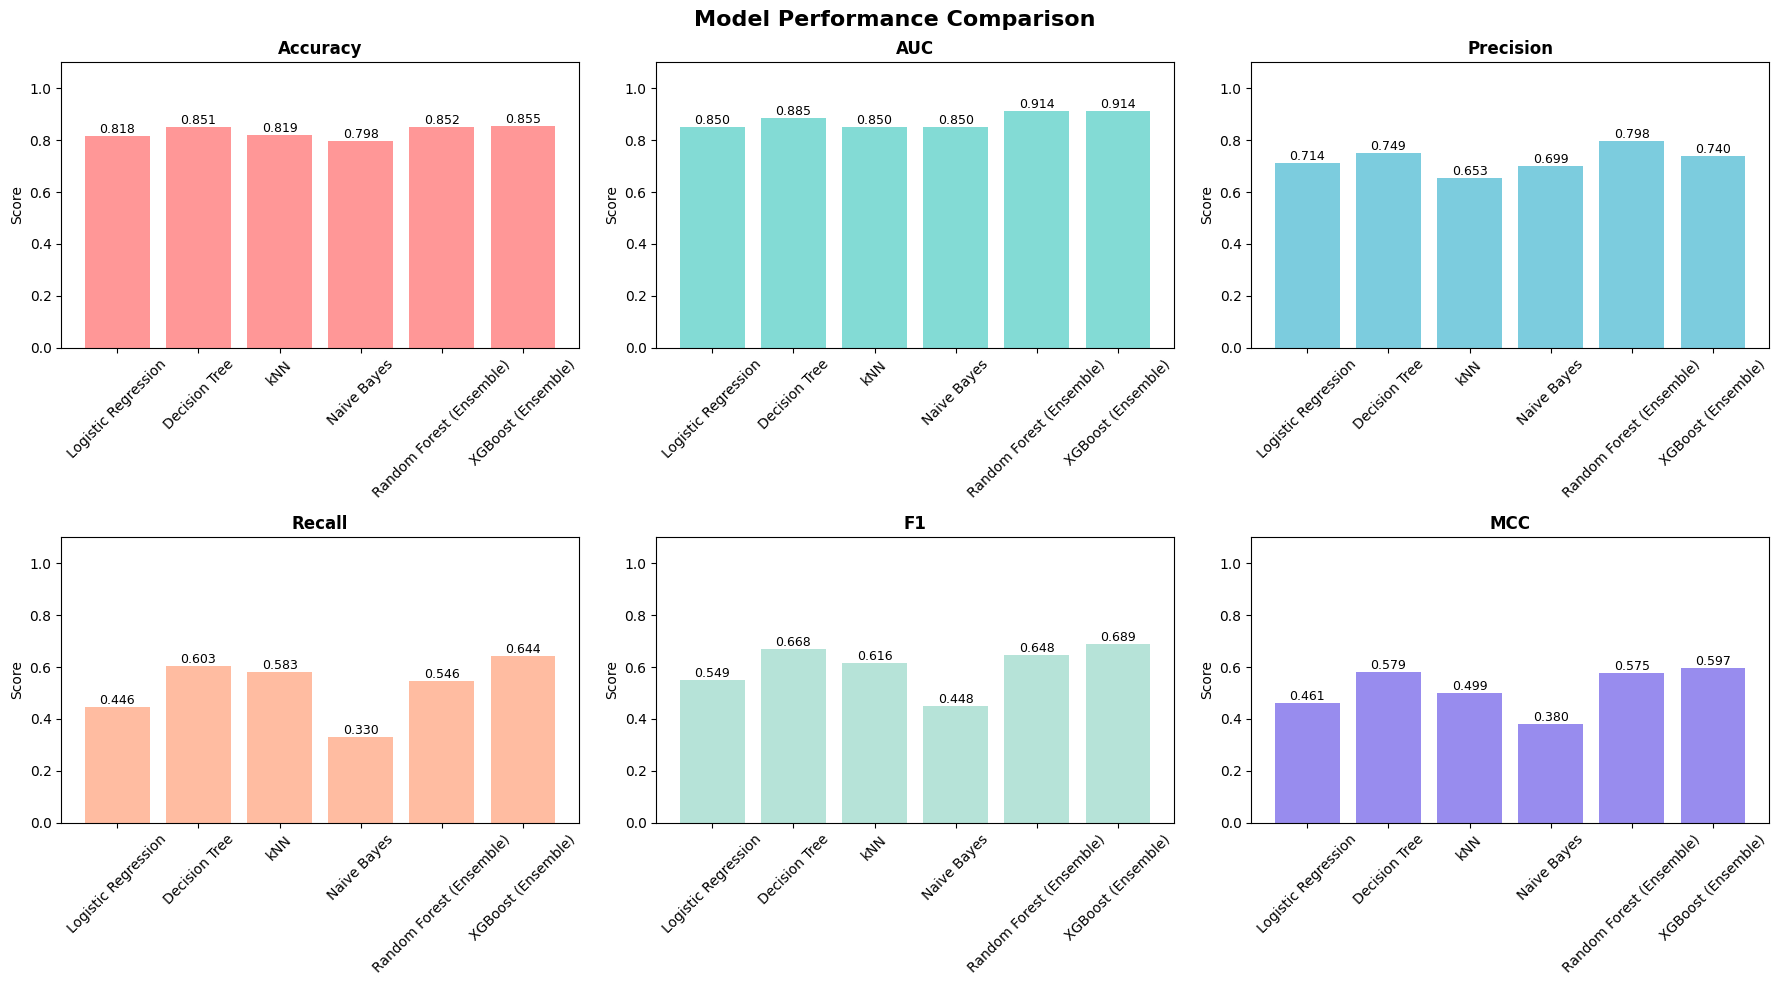

Visualization saved to 'model/model_comparison.png'


In [ ]:
# Plot model performance comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics_to_plot = ['Accuracy', 'AUC', 'Precision', 'Recall', 'F1', 'MCC']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#6C5CE7']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    ax = axes[idx // 3, idx % 3]

    if metric == 'AUC' and comparison_df['AUC'].dtype == 'object':
        ax.text(0.5, 0.5, 'AUC not available', ha='center', va='center')
        ax.set_title(metric)
    else:
        bars = ax.bar(comparison_df['ML Model Name'], comparison_df[metric], color=color, alpha=0.7)
        ax.set_title(metric, fontsize=12, fontweight='bold')
        ax.set_ylabel('Score')
        ax.set_ylim([0, 1.1])
        ax.tick_params(axis='x', rotation=45)

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to 'model/model_comparison.png'")

## Model Performance Observations

### Individual Model Analysis:

**1. Logistic Regression:**
Good starting point with 81.8% accuracy, but struggles to find high earners (only 45% recall). It's playing it safe by mostly predicting the common class (≤50K income). Works fast and simple, but misses too many high-income people to be fully useful.

**2. Decision Tree:**
Strong performer at 85.1% accuracy. Does a much better job finding high earners (60% recall) than Logistic Regression. When it predicts someone earns >50K, it's right about 75% of the time. Good balance between precision and recall.

**3. K-Nearest Neighbors (kNN):**
Middle performer at 81.9% accuracy. Finds a decent number of high earners (58% recall) but precision is lower (65%). With 14 features and 30,000 people, it struggles a bit. Also really slow to make predictions.

**4. Naive Bayes:**
Weakest performer at 79.8% accuracy. Worst at finding high earners (only 33% recall). Too cautious and misses most actual high-income individuals. Super fast to train though, which makes it good for quick baseline tests.

**5. Random Forest (Ensemble):**
Most precise model (80%) with great accuracy (85.3%) and excellent AUC (0.914). When it says someone earns >50K, it's usually right. But it's cautious and misses some actual high earners (55% recall). Good if you hate false alarms.

**6. XGBoost (Ensemble):**
**Winner overall.** Best at finding high earners (64% recall) while keeping excellent accuracy (85.5%) and AUC (0.914). Most balanced across all measures with best F1 (0.689) and MCC (0.597). Handles the imbalanced data better than everything else.

### Key Takeaways:

**Best Model:** XGBoost wins. It finds the most high-income people without sacrificing accuracy. Best overall balance with highest F1 and MCC scores.

**Ensemble Power:** Random Forest and XGBoost significantly outperformed basic models, especially in AUC scores (0.91+ vs 0.85). Combining multiple models clearly works better.

**Biggest Difference:** Recall varied dramatically (33% to 64%). Shows how differently each model handles imbalanced data.

**Trade-off:** Random Forest is super precise (80%) but cautious (55% recall). XGBoost is slightly less precise (74%) but finds way more people (64% recall). For this task, finding high earners matters more, so XGBoost wins.

**Surprise:** Naive Bayes performed worst despite being popular. Too conservative with predictions. kNN also struggled with the high-dimensional space.

**The Imbalance Problem:** All models are decent at accuracy (80-85%) but varied wildly at finding high earners (33-64% recall). That's because 75% of people earn ≤50K, so models can get high accuracy by just guessing "low income" often.

**Bottom Line:** Use XGBoost. It's the most reliable at actually identifying both income groups with the best overall metrics.